### Imports

In [3]:
import itertools
from tqdm.notebook import tqdm
import json
from datasets import load_dataset
from elasticsearch import Elasticsearch


### Load dataset

In [4]:
dataset = load_dataset("clarin-knext/fiqa-pl", 'corpus')
pd_dataset = dataset['corpus'].to_pandas()

In [5]:
from spacy.lang.pl import Polish
nlp = Polish()
tokenizer = nlp.tokenizer

In [10]:
pd_dataset.iloc[0]['text']

'Nie mówię, że nie podoba mi się też pomysł szkolenia w miejscu pracy, ale nie możesz oczekiwać, że firma to zrobi. Szkolenie pracowników to nie ich praca – oni tworzą oprogramowanie. Być może systemy edukacyjne w Stanach Zjednoczonych (lub ich studenci) powinny trochę martwić się o zdobycie umiejętności rynkowych w zamian za ich ogromne inwestycje w edukację, zamiast wychodzić z tysiącami zadłużonych studentów i narzekać, że nie są do niczego wykwalifikowani.'

In [19]:
tokens = tokenizer(pd_dataset.iloc[0]['text'])

TypeError: Cannot index by location index with a non-integer key

In [15]:
len(tokens)

81

In [27]:
from collections import defaultdict
frequency_list = defaultdict(lambda: 0)
texts = pd_dataset['text'].apply(lambda s: s.lower())
for doc in tokenizer.pipe(texts, batch_size=50):
    for token in doc:
        frequency_list[token.text] += 1

In [28]:
frequency_list

defaultdict(<function __main__.<lambda>()>,
            {'nie': 131355,
             'mówię': 977,
             ',': 611388,
             'że': 90021,
             'podoba': 499,
             'mi': 5497,
             'się': 85835,
             'też': 3989,
             'pomysł': 1402,
             'szkolenia': 136,
             'w': 175120,
             'miejscu': 1159,
             'pracy': 7281,
             'ale': 41228,
             'możesz': 23208,
             'oczekiwać': 396,
             'firma': 6276,
             'to': 116324,
             'zrobi': 428,
             '.': 399567,
             'szkolenie': 108,
             'pracowników': 2207,
             'ich': 14567,
             'praca': 1329,
             '–': 8761,
             'oni': 1242,
             'tworzą': 221,
             'oprogramowanie': 459,
             'być': 19261,
             'może': 26331,
             'systemy': 315,
             'edukacyjne': 59,
             'stanach': 1200,
             'zjednoczon

In [39]:
import pandas as pd
pd_frequency_list = pd.DataFrame(frequency_list.items(), columns=['token', 'count'])
pd_frequency_list_filtered = pd_frequency_list[pd_frequency_list['token'].apply(lambda x: len(x)>2)]

In [40]:
pd_frequency_list.shape, pd_frequency_list_filtered.shape

((188516, 2), (187070, 2))

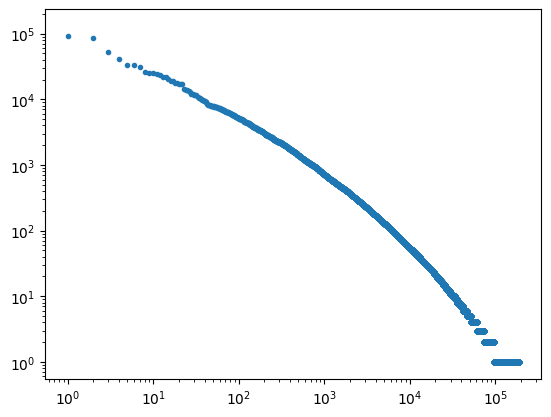

In [54]:
import matplotlib.pyplot as plt

df = pd_frequency_list_filtered.sort_values(by='count', ascending=False).reset_index()
plt.yscale('log')
plt.xscale('log')
plt.plot(df['count'], '.')


In [57]:
from morfeusz2 import Morfeusz

morfeusz = Morfeusz()
morfeusz.analyse() # w for jak w przykładzie i z wyniku ign oznacza czy jest w słowniku


'Copyright © 2007–2023 Marcin Woliński, Zbigniew Bronk, Włodzimierz Gruszczyński, Witold Kieraś, Zygmunt Saloni, Danuta Skowrońska, Robert Wołosz\r\n\r\nAll rights reserved.\r\n\r\nRedistribution and use in source and binary forms, with or without\r\nmodification, are permitted provided that the following conditions are\r\nmet:\r\n\r\nRedistributions of source code must retain the above copyright notice,\r\nthis list of conditions and the following disclaimer.\r\nRedistributions in binary form must reproduce the above copyright\r\nnotice, this list of conditions and the following disclaimer in the\r\ndocumentation and/or other materials provided with the distribution.\r\n\r\nTHIS SOFTWARE IS PROVIDED BY COPYRIGHT HOLDERS “AS IS” AND ANY EXPRESS\r\nOR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED\r\nWARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE\r\nDISCLAIMED. IN NO EVENT SHALL COPYRIGHT HOLDERS OR CONTRIBUTORS BE\r\nLIABLE FOR ANY DIRECT, INDIRE

### Configure ElasticSearch

In [173]:


ELASTIC_PASSWORD = 'tZSE8E-JJ+*FT07ID30Q'
client = Elasticsearch(
    "https://localhost:9200",
    ca_certs="../../http_ca.crt",
    basic_auth=("elastic", ELASTIC_PASSWORD)
)

client.info()


ObjectApiResponse({'name': '8aa7680e5b7b', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'GUnOVmh2TI6YXU9DaPLQ4g', 'version': {'number': '8.8.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '98e1271edf932a480e4262a471281f1ee295ce6b', 'build_date': '2023-06-26T05:16:16.196344851Z', 'build_snapshot': False, 'lucene_version': '9.6.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

### Define two ES analyzers for Polish according to requirements.
### Define an ES index for storing the contents of the corpus from lab 1 using both analyzers. 

Analyzers and other settings are defined in `settings.json` file. 
Synonyms used in analyser are defined in `synonyms.txt` file 


In [175]:
! docker cp ./synonyms.txt es01:/usr/share/elasticsearch/config 

In [176]:
INDEX_NAME = "months_index"
settings = json.load(open('./settings.json', 'r'))
client.indices.delete(index=INDEX_NAME)
client.indices.create(index=INDEX_NAME, settings=settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'months_index'})

### Load the data to the ES index.

In [177]:
body = list(itertools.chain(*pd_dataset.apply(lambda x: ({'index': {'_id': x._id}}, {'title': x.title, 'text': x.text}) , axis=1)))
chunk_size = 200
for chunk in tqdm([body[i:i + chunk_size] for i in range(0, len(body), chunk_size)]):
    client.bulk(
        index=INDEX_NAME,
        body=chunk
    )

  0%|          | 0/577 [00:00<?, ?it/s]

### Determine the number of documents containing the word styczeń (in any form) including and excluding the synonyms.

In [189]:
c1 = client.count(index=INDEX_NAME,  analyzer='analyzer_with_synonym', q='text:styczeń')['count']
c2 = client.count(index=INDEX_NAME,  analyzer='analyzer_without_synonym', q='text:styczeń')['count']

In [190]:
print(f"""
    Styczeń matches with synonyms:       {c1}
    Styczeń matches withotu synonyms:    {c2}""")


    Styczeń matches with synonyms:       44123
    Styczeń matches withotu synonyms:    29


Synonyms for Styczeń contains also "I" which is "and" word in Polish, so count of matches with synonyms is inadequate.

In [191]:
c1 = client.count(index=INDEX_NAME,  analyzer='analyzer_with_synonym', q='text:sierpień')['count']
c2 = client.count(index=INDEX_NAME,  analyzer='analyzer_without_synonym', q='text:sierpień')['count']

In [192]:
print(f"""
    Sierpień matches with synonyms:       {c1}
    Sierpień matches withotu synonyms:    {c2}""")


    Sierpień matches with synonyms:       50
    Sierpień matches withotu synonyms:    22


Number of Sierpień occurences are more accurate and realistic.  

### Download the QA pairs for the FIQA dataset. (what should be done here?, how to get started with that ds?)


In [209]:
QA_dataset = load_dataset("clarin-knext/fiqa-pl-qrels", 'corpus')


In [210]:
QA_dataset['train']

Dataset({
    features: ['query-id', 'corpus-id', 'score'],
    num_rows: 14166
})

1. What are the strengths and weaknesses of regular expressions versus full text search regarding processing of text?
Regular expressions are simpler, easier to configure and for easy patterns are fast, but it is hard to create expression that covers every form. ElasticSearch needs to be configured, indexes need to be defined and data is required to be stored in ES, but it supports tokenization, lematization, and has many build-in filters. Searching and counting is very fast thanks to database system and indexes. 
2. Is full text search applicable to the question answering problem? Show at least 3 examples from the corpus to support your claim.